## 项目描述

CharityML 是一家位于硅谷核心地带的慈善机构，它致力于为想学机器学习的学生提供经济上的帮助。在社区中发出了32000多封捐赠信之后，他们发现他们收到的每一笔捐赠，都来自年收入5万美金以上的人。为了拓展他们的捐赠池，CharityML决定向加州居民发送一封信，信只发给那些最有可能捐助的人。因为加州的工作人群有一千五百万， CharityML雇佣你来帮他们构建一个最好的算法，来识别最有可能的捐赠者以降低发送信件的成本。你的目标是评估和优化几个不同的监督学习算法来决定哪个算法能给出最高的捐赠者识别率，以降低总计的发信数量。

## 使用的数据


这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。可以直接从网站下载该数据集（该数据集来自于1994年的人口普查数据），并且网站上会有一些简单的描述。不过不要紧，我待会儿就会进行数据的探索，打印一些数据的基本信息。

----
## 探索数据
下面我们使用pandas载入数据集，需要注意的是数据集的最后一列`'income'`将是我们需要预测的列（表示被调查者的年收入会大于或者是最多50,000美元），人口普查数据中的每一列都将是关于被调查者的特征。

In [1]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


上面的结果告诉我们数据集有13个特征，其中age，education-num，capital-gain，capital-loss，hours-per-week属于连续的特征，其他的特征属于类别特征。接下来我们将看看总共有多少被调查者？并且在每一类别中年薪50K以上或者以下人员的分布情况？

In [2]:
# 总的记录数
n_records = data['income'].size

# 被调查者的收入大于$50,000的人数
n_greater_50k = (data['income'] == '>50K').sum()

# 被调查者的收入最多为$50,000的人数
n_at_most_50k = n_records - n_greater_50k

# 被调查者收入大于$50,000所占的比例
greater_percent = n_greater_50k/float(n_records) * 100

# 打印结果
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## 准备数据
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - 这通常被叫做**预处理**。幸运的是，对于这个数据集，没有我们必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助我们提升几乎所有的学习算法的结果和预测能力。

### 获得特征和标签
`income` 列是我们需要的标签，记录一个人的年收入是否高于50K。 因此我们应该把他从数据中剥离出来，单独存放。

In [3]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

### 转换倾斜的连续特征

一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平凡分布的的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。在人口普查数据集的两个特征符合这个描述：'`capital-gain'`和`'capital-loss'`。

运行下面的代码单元以创建一个关于这两个特征的条形图。请注意当前的值的范围和它们是如何分布的。

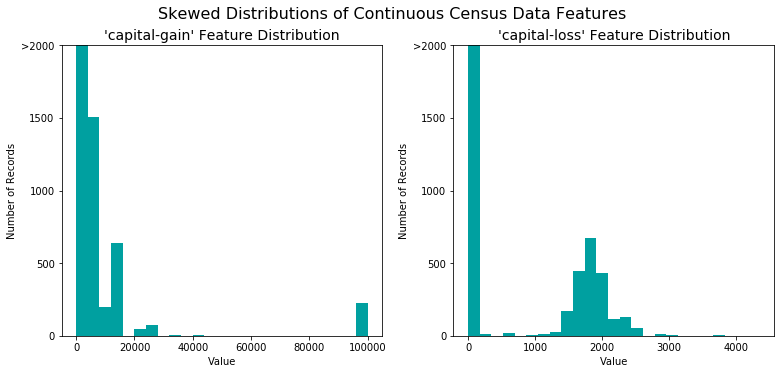

In [4]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

对于高度倾斜分布的特征如`'capital-gain'`和`'capital-loss'`，常见的做法是对数据施加一个对数转换，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换。

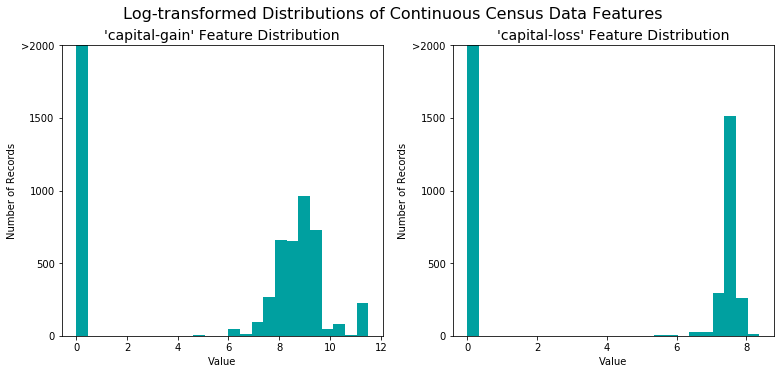

In [5]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

### 规一化数字特征
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放(也就是归一化，对数据做平移和缩放)并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待，并且能够起到加快算法收敛速度的作用(详见吴恩达机器学习课程)。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了，就像下面的例子展示的。

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.140841,0.0,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.051781,0.0,0.397959,United-States


如上图所示，我将连续特征都归一化到0-1之间了，这边与我们之后算法的处理。

### 练习：数据预处理

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。在类别特征的转换分为两种情况，第一是类别特征的取值有大小关系，比如衣服的size分为L，XL，XXL，那么就可以直接映射为1,2,3。如果类别的取值之间没有明显的大小关系，比如我们使用的数据集，那么一种常用的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

| 特征X |                    | 特征X_A | 特征X_B | 特征X_C |
| :-: |                            | :-: | :-: | :-: |
|  B  |  | 0 | 1 | 0 |
|  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
|  A  |  | 1 | 0 | 0 |

此外，对于非数字的特征，我们需要将非数字的标签`'income'`转换成数值以保证学习算法能够正常工作。因为这个标签只有两种可能的类别（"<=50K"和">50K"），我们不必要使用独热编码，可以直接将他们编码分别成两个类`0`和`1`

In [7]:
# T使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# 将'income_raw'编码成数字值
#income = (income_raw == '>50K').astype(int)
income = income_raw.map({'>50K':1, '<=50K':0})
# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# 移除下面一行的注释以观察编码的特征名字
#print encoded

103 total features after one-hot encoding.


### 混洗和切分数据
现在所有的 _类别变量_ 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。由于数据一共是4万多条，并不是特别多，所以划分为其中80%的数据将用于训练和20%的数据用于测试。然后再进一步把训练数据分为训练集和验证集，用来选择和优化模型。

In [8]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)
# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


----
## 评价模型性能
在这一部分中，我们将尝试四种不同的算法，并确定哪一个能够最好地建模数据。四种算法包含一个*天真的预测器* (呵呵，待会儿就知道什么是天真啦)和三个你选择的监督学习器。

### 设定评估标准
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**查全**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

查准率：算法认为大于50K的样本中，实际上也是大于50K的样本的比例

查全率：在所有大于50K的样本中，算法检测出来的真正大于50K的样本的比例

F-score:当β=1时，称为F1-score，这时，精确率和召回率都很重要，权重相同。当有些情况下，我们认为精确率更重要些，那就调整β的值小于1，如果我们认为召回率更重要些，那就调整β的值大于1。

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当 $\beta = 0.5$ 的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

天真的预测器的性能

通过查看收入超过和不超过 \$50,000 的人数，我们能发现多数被调查者年收入没有超过 \$50,000。如果我们简单地预测说*“这个人的收入没有超过 \$50,000”*，我们就可以得到一个 准确率超过 50% 的预测。这样我们甚至不用看数据就能做到一个准确率超过 50%。这样一个预测被称作是天真的。通常对数据使用一个*天真的预测器*是十分重要的，这样能够帮助建立一个模型表现是否好的基准。 使用下面的代码单元计算天真的预测器的相关性能。现在我们将计算结果赋值给`'accuracy'`, `‘precision’`, `‘recall’` 和 `'fscore'`，这些值会在后面被使用  

下面实现一个天真的预测期，实现无论输入什么内容，都预测为“其年收入超过50K”


In [9]:
#TODO： 计算准确率
accuracy = (y_val.sum())/float(y_val.size)

# TODO： 计算查准率 Precision
precision = y_val.sum()/float(y_val.size)

# TODO： 计算查全率 Recall
recall = y_test.sum()/float(y_test.sum())

# TODO： 使用上面的公式，设置beta=0.5，计算F-score
fscore = (1+0.5**2) * (precision * recall)/float((0.5**2*precision) + recall)

#打印结果
print ("Naive Predictor on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore))

Naive Predictor on validation data: 
     Accuracy score: 0.2478 
     Precision: 0.2478 
     Recall: 1.0000 
     F-score: 0.2917


## 监督学习模型

之前我们说过，要选定三个模型来对数据集进行拟合，其实这是一个经验的过程。根据对这些算法的优缺点的总结以及网上的朋友的调参经验，选定了如下三个模型，其中随机森林和支持向量机总是可以先尝试的，决策树纯粹是一个作为对照的模型。

下面我对这三个算法做一些小小的分析，说明其优点和缺点，以及其应用场景。

### 模型1

**模型名称**

回答： <font color=#009500 size=2>决策树</font>


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：* <font color=#009500 size=2>比如说用决策树模型预测今天晚上看不看udacity的机器学习课程。</font>

1. <font color=#009500 size=2>第一个结点，今天是否加班？如果今天加班，直接输出结果：不看了，睡觉。</font>
2. <font color=#009500 size=2>下一个结点，否则看看到家的时间，是否小于8点？如果大于八点，直接输出结果不看了。</font>
3. <font color=#009500 size=2>下一个结点，今天是否有约会？如果有约会，直接输出结果：约会去（虽然。。。）
否则，输出结果：上课</font>

**这个模型的优势是什么？他什么情况下表现最好？**

回答：
* <font color=#009500 size=2>优势：</font>
1. <font color=#009500 size=2>1，决策树模拟人的决策过程，所以很容易被理解</font>
2. <font color=#009500 size=2>2，决策树的每一个结点的决策只考虑单个特征，利用decision stump来进行切割，所以决策树无论在训练还是预测，都是比较快速的。</font>
3. <font color=#009500 size=2>3，决策树在预测的时候，可以通过备用分支来解决特征值缺失的问题（在训练的时候会为当前分支准备一个或者多个备用分支，备用分支的选择准则大概是：备用分支和当前分支的样本划分结果由很大的重合）</font>


**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
* <font color=#009500 size=2>劣势：</font>
1. <font color=#009500 size=2>1，决策树容易过拟合，特别是一个fully-grown-tree,所以需要好好进行决策树的剪枝</font>
2. <font color=#009500 size=2>2，决策树的方差比较大，也就是对于小的训练数据的变化容易产生不一样的决策树。一般决策树用于集成学习的base algorithm，而不单独使用</font>
3. <font color=#009500 size=2>3，决策树没有统一的算法，比如基于C&RT或者ID3、C4.5等等，而且每个算法还需要进行剪枝（这也算不算一种缺点？）</font>

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：<font color=#009500 size=2>我们的应用是根据被调查这的特征来判断一个人的年收入，本来该问题就是一个很有解释性的问题，比如一个人资产状况很好，没有负债，且毕业于名牌大学，那这个人很有可能年收入超过50K。而且我们的决策树模型也是很有解释性的，所以我感觉很适合</font>

### 模型2

**模型名称**

回答：<font color=#009500 size=2>支撑向量机</font>


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：<font color=#009500 size=2>我们都知道，支撑向量机是一款最优间隔分类器，何为最优？最优就是使距离分割面的最小距离最大就是最优。一款基于几何距离的模型，在现实中实在找不出什么好的比喻。</font>

**这个模型的优势是什么？他什么情况下表现最好？**

回答：* <font color=#009500 size=2>优势：</font>
1. <font color=#009500 size=2>SVM能够轻易处理高纬度的特征，因为对偶的SVM移除了对特征维度的依赖，所以处理高维度特征更加快捷。由于算法的求解不依赖于特征的维度，所以我们可以任性地进行特征转换，并且可以利用核技巧，使高维度甚至无限维度的特征转换成为可能</font>
2. <font color=#009500 size=2>SVM利用最大间隔分割面的思想，使算法本身就带有正则化的效果，无需额外添加正则项（SVM的损失函数可以看成是带有L2正则项的合页损失函数，所以其自带正则项）</font>
3. <font color=#009500 size=2>SVM对偶问题的解具有稀疏性，所以假设函数只由少量的位于边界的点组成，比较简单，预测速度较快。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：* <font color=#009500 size=2>劣势：</font>
1. <font color=#009500 size=2>虽然利用核函数（高斯核）可以进行无限维的转换，但是要小心地选取惩罚系数C和高斯核的γ或者其他核的超参数，否则很容易造成过拟合。
2. <font color=#009500 size=2>在SVM的对偶问题中，我们将求解和特征维度相关的W的问题转换为了求解和样本数量相关的an的问题，虽然这带来了很多好处（进行任意特征转换，而不用担心求解困难），但是当我们的样本数量巨大的时候，二次规划问题求解的未知数变得更多，二次规划问题的求解将变得困难，需要专门设计的二次规划程序来求解。而且样本数量N特别多的时候，二次规划问题的Q矩阵（大小为N*N）的存储将变得困难。</font>

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：<font color=#009500 size=2>上面的诸多优点说明，SVM是一款比较稳定可靠的模型，对于一般问题来说，SVM总是可以先尝试的模型（网上大佬说的，大家都说好那就好吧）。针对上述的缺点，我们可以利用网格搜索交叉验证来小心选择SVM的超参数，避免出现过拟合。而且我们的训练样本是3W多个，也不算特别巨大（不太清楚对于传统机器学习算法来说3W多算不算巨大）。所以缺点我们基本上都可以克服，并且又有那么多优点，那就试试吧！</font>

### 模型3

**模型名称**

回答：<font color=#009500 size=2>Random Forest，随机森林</font>


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：<font color=#009500 size=2>哈哈，之前选择了决策树，用于预测下班到家要不要看机器学习课程，但是我们说了，决策树这个东西它很不稳定，数据的一点儿变动就可能训练出另一棵完全不同的决策树。那既然这样，我们就抽取出不同的子训练集来训练很多棵树，让他们来投票，多数取胜。如果多数的结果认为我应该看书，那我就看书，否则不看。</font>

**这个模型的优势是什么？他什么情况下表现最好？**

回答：
1. <font color=#009500 size=2>random forest的random来自于bagging，forest 来自于决策树。可以利用bagging的并行运算的优点并行训练模型，而且可以决策树本身就是很有效率的，所以random forest算法整体就显得很有效率。</font>
2. <font color=#009500 size=2>继承了所有决策树的优点，能够很好地处理类别特和缺失特征</font>
3. <font color=#009500 size=2>由于集成学习的原因，所以我们训练的决策树不需要进行剪枝，并且投票机制可以帮助我们消除大部分的噪声</font>
4. <font color=#009500 size=2>random forest采用bagging的原因，所以可以利用bagging只随机抽取部分训练集的特征来进行self validation(显然我们用不到该特性，因为我们专门划分了验证集)</font>
**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
1. <font color=#009500 size=2>我们的训练结果受random seed的影响，特别是在树的数量小的时候，具体的影响就是bagging的时候选择样本和feature projection（随机森林的决策树中特有的特征投影），虽然不知道这会造成什么不好的影响，但是随机性肯定不是我们想要的(我也不知道这是不是一种问题，但是随机森林本来问题就少，那就找点儿吧)</font>
2. <font color=#009500 size=2>对数据量少或者维度低的数据集效果可能不是太好。可能是因为特征少，决策树的分支决策的选择就少，随着决策树数量的增加，导致学习的大多决策树都很相似，不符合集成学习的diversity的要求(这个缺点是在网上找的，原因是自己分析的，不知道对不对，请老师指正)</font>

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：<font color=#009500 size=2>因为我们的base algorithm采用的是决策树，决策树本身具有很好的解释性(虽然在随机森林中，采用了feature projection可能导致这种解释性消失)。如果上述的第二个缺点成立的话，那么很有可能随机森林不适合我们的数据，但是我们的数据量也不算太少，是否能够弥补特征维度较少产生的缺点，看实际效果吧。</font>

### 创建一个评价函数
为了正确评估你选择的每一个模型的性能，创建一个能够快速有效地使用不同大小的训练集并在验证集上做预测的训练和验证的流水线是十分重要的。
在这里实现的功能将会在接下来的部分中被用到。该函数实现的功能为：

用训练集拟合学习器，并记录训练时间。

对训练集的前300个数据点和验证集进行预测并记录预测时间。

计算训练集的前300个数据点的准确率和F-score。

计算验证集的准确率和F-score。

In [10]:
# TODO：从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    # 使用sample_size大小的训练数据来拟合学习器
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # 获得程序开始时间
    learner = learner.fit(X_train.iloc[:sample_size, :], y_train.iloc[:sample_size])
    end = time() # 获得程序结束时间
    
    # 计算训练时间
    results['train_time'] = round(end-start,2)
    
    # 得到在验证集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train.iloc[:300, :])
    end = time() # 获得程序结束时间
    
    # 计算预测用时
    results['pred_time'] = round(end-start,2)
            
    # 计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train.iloc[:300], predictions_train)
        
    # 计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    # 计算在最前面300个训练数据上的F-score
    # beta选择0.5是因为之前说了我们更重视查准率，采用默认的average参数使其返回默认的正样本额fbeta-score
    results['f_train'] = fbeta_score(y_train.iloc[:300], predictions_train, beta=0.5)
        
    # 计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, beta=0.5)
       
    # 成功
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

### 初始模型的评估

利用上面写的函数，我们分别从训练时间，accuracy，F-score三个方面来比较这三个模型的表现，从而决定选择哪个模型进行进一步地调参。（注意：这一步中创建分类器时，只是用模型参数）

DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
SVC trained on 289 samples.


/home/riki/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 2894 samples.
SVC trained on 28941 samples.
RandomForestClassifier trained on 289 samples.
RandomForestClassifier trained on 2894 samples.
RandomForestClassifier trained on 28941 samples.


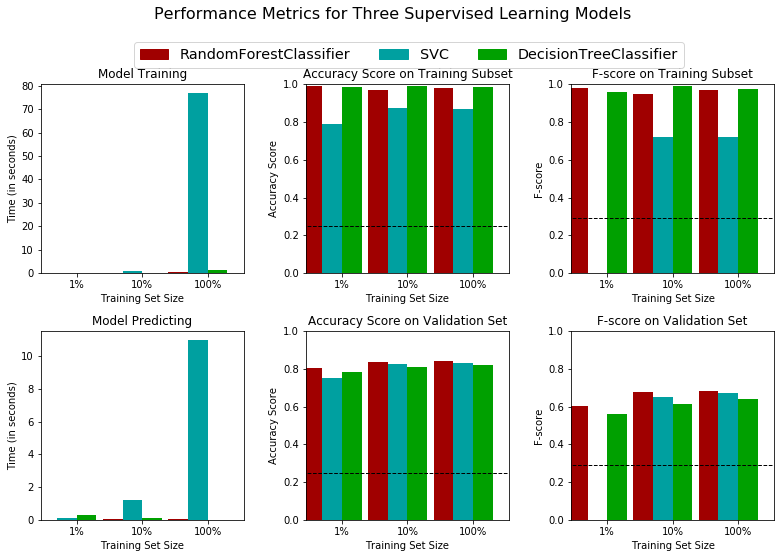

In [11]:
# TODO：从sklearn中导入三个监督学习模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# TODO：初始化三个模型

# 决策树模型，题目要求采用默认参数并且设置random_state
clf_A = DecisionTreeClassifier(random_state=0)

# SVM模型, 题目要求采用默认参数并且设置random_state
clf_B = SVC(random_state=0)

# 随机森林模型, 题目要求采用默认参数并且设置random_state
clf_C = RandomForestClassifier(random_state=0)

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
sample_len = len(X_train)

samples_1 = sample_len//100
samples_10 = sample_len//10
samples_100 = sample_len

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

###  选择最佳的模型

下面我将基于前面做的结果，从评价指标，预测/训练时间等方面来解释解释这三个模型中哪一个对于判断被调查者的年收入大于 \$50,000 是最合适的。      


1. <font color=#009500 size=2>首先从训练以及预测时间上来看。基于决策树的两个模型（决策树和随机森林）展现了超高的训练效率，其预测时间秒杀SVM。当采用全部训练集的时候，SVM的训练时间超过60S，而其他两个基于决策树的模型不到1S。从预测时间来看也是如此，难道是因为SVM的支撑向量过多导致预测时间长达10S？</font>
2. <font color=#009500 size=2>其次从评价指标上来看。先看基于训练集的指标，在训练集的accuracy和fbeta-score中，基于决策树的两个模型的分数依然远高于SVM，并且随机森林模型表现最好。而且在1%样本的时候，SVM的fbeta-score出现了0的情况，我的猜想是此时由于样本数量较少，且正样本的数量更是少，在这SVM采用的是默认的C=1.0，那么SVM就偏向了将所有数据都预测为负的label（就像天真的预测器），基本没有正样本的预测，再加上惩罚系数C也不是很大，所以SVM就用错误的分类来换取更宽的边界，这样就导致在计算fbeta-score的时候，分子分母均为零(训练过程中打印的那个警告就是这个原因造成的)，所以我们的fbeta函数把分数设置为0。对于验证集，我们发现，基于决策树的模型都展现了比较高的方差，其accuracy和fbeta-score相对于训练集都出现了很大的程度的降低，我猜测出现这样的原因是因为我们基于决策树的模型都采用的默认参数，也就是生成的都是fully-grown-tree，或者说自然生长的树，未剪枝的树都是具有很高的方差的，可能是由于集成的原因，随机森林比决策树的方差情况要稍稍好一点儿，但是也不乐观。相对而言，SVM的方差问题就不那么严重了，之前分析SVM的时候说过，SVM自带L2正则项，自带正则化的效果。至于在训练集大小为1%的时候，SVM的fbeta-score为0的原因和上面分析的一样。</font>
3. <font color=#009500 size=2>偏差分析。偏差分析主要看模型在训练集上的拟合效果，从上图可以看出，基于决策树的模型表现出了较低的方差，这也在意料之内，毕竟是完全生长的树。但是SVM模型出现了明显的偏差问题。三个数据集大小的情况下，SVM的分数都较低，并且数据集大小从10%到100%的时候，分数基本没有提升，所以接下来如果要优化SVM的话提升数据集大小是没有帮助的，应该想办法来让SVM产生更复杂的边界，比如更大的C或者更大的γ(高斯核)等等</font>
4. <font color=#009500 size=2>方差分析。方差分析主要看模型在验证集上的拟合效果以及验证集和训练集的分数之差。粗略看，基于决策树的模型出现了较大的方差问题，而SVM相对而言没有那么严重。上面我们说过了SVM存在较大的偏差问题，所以对于SVM还是先把偏差问题搞定之后再讨论方差吧。对于验证集的分数，当我们的数据集大小从1%提高到%10的时候，各个基于决策树的模型的分数有所提高，说明增大数据集解决了一点儿方差问题。但是数据集大小从10%增大到100%的时候，各个模型的验证集分数并没有明显的提高。那么此时我们应该另寻减小方差的方法。使基于决策树的模型形成更平滑的边界，比如决策树剪枝？训练更长时间？（对于随机森林来说，也就是生成更多的小h，小的决策树，不知道有没有这个参数可以调节）
    
* <font color=#009500 size=2>综上所述，由于SVM展现了较低的训练和预测效率，还有比较大的偏差问题，所以暂时就不考虑SVM了。决策树和随机森林之间肯定选择随机森林咯。

### 模型调优
调节选择的模型的参数。我将使用网格搜索（GridSearchCV）来调整模型的重要参数，我将至少需尝试3个不同的值。这次我会使用整个训练集来完成这个过程。

In [13]:
#导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import time
#初始化分类器
clf = RandomForestClassifier(random_state=0)

# 创建调节的参数列表
"""
parameters = [
    {
        "n_estimators":[10,16,32,64,128,256,512,1024],
        "min_samples_leaf":[1,2,4,8,16,32,64],
        "max_depth":[1,2,4,8,16,None]
    },
]
"""
parameters = [
    {
        "n_estimators":[128],
        "min_samples_leaf":[4],
        "max_depth":[16]
    },
]
# 创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# 在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=10)

# 用训练数据拟合网格搜索对象并找到最佳参数
start = time.time()
grid_obj.fit(X_train, y_train)
end = time.time()

# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5))
print "\nOptimized Model(training time %.2f s)\n------" % (round(end-start, 2))
print "Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on validation data: 0.8389
F-score on validation data: 0.6812

Optimized Model(training time 35.92 s)
------
Final accuracy score on the validation data: 0.8611
Final F-score on the validation data: 0.7419


In [14]:
## 分别获得天真模型，未优化模型和优化的模型在测试集上的各项指标


## Naive predictor
naive_y_pred = pd.Series([1 for x in range(y_test.size)])
naive_test_accuracy = accuracy_score(y_test, naive_y_pred)
naive_test_fbeta_score = fbeta_score(y_test, naive_y_pred, beta = 0.5)

## default predictor
clf.fit(X_train, y_train)
start = time.time()
default_y_pred = clf.predict(X_test)
end = time.time()
default_pred_time = round(end-start, 2)
default_test_accuracy = accuracy_score(y_test, default_y_pred)
default_test_fbeta_score = fbeta_score(y_test, default_y_pred, beta = 0.5)

## optimal predictor
start = time.time()
opt_test_pred = best_clf.predict(X_test)
end = time.time()

opt_pred_time = round(end-start, 2)
opt_test_accuracy = accuracy_score(y_test, opt_test_pred)
opt_test_fbeta_score = fbeta_score(y_test, opt_test_pred, beta = 0.5)

best_predictions = best_clf.predict(X_val)
print ("Naive Predictor----accuracy:{0:.2f}   fbeta score:{1:.2f}".format(naive_test_accuracy, naive_test_fbeta_score))
print ("Default Predictor----accuracy:{0:.2f}   fbeta score:{1:.2f}  predict time:{2:.2f} s".format(default_test_accuracy, default_test_fbeta_score, 
                                                                           default_pred_time))
print ("Optimal Predictor----accuracy:{0:.2f}   fbeta score:{1:.2f}  predict time:{2:.2f} s".format(opt_test_accuracy, opt_test_fbeta_score,
                                                                                                 opt_pred_time))

print (best_clf)

Naive Predictor----accuracy:0.25   fbeta score:0.29
Default Predictor----accuracy:0.83   fbeta score:0.67  predict time:0.03 s
Optimal Predictor----accuracy:0.86   fbeta score:0.74  predict time:0.16 s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


#### 结果:
 
| 评价指标         | 天真预测器           | 未优化的模型        | 优化的模型        |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| 准确率          |      0.25               |        0.83           |        0.86         |
| F-score        |        0.29            |          0.67         |         0.74        |


* <font color=#009500 size=2>以下结果均基于测试集</font>
1. <font color=#009500 size=2>1，分数有所提升：优化模型在测试数据上的准确率和f-score分别为0.86和0.74，相对于未优化的模型的准确率0.83和f-score0.67来说有一定的提升。</font>
2. <font color=#009500 size=2>2，训练时间大大增加：未优化的模型的训练时间可以忽略不计，但是优化的模型的训练时间将近三个小时。</font>
3. <font color=#009500 size=2>3，预测时间小幅度提升：未优化的模型的预测时间为0.02s，优化后的模型时间为0.15秒。对于这个时间我想大多数的应用都可以接受，所以这个不是问题。</font>
4. <font color=#009500 size=2>4，天真的预测器：其在测试集的分数为0.25和0.29，比起优化过的预测器差太多。</font>
5. <font color=#009500 size=2>5，结论：总的来说优化过的模型比未优化过的模型和天真的模型的效果要好，但是分数我个人感觉也不是太理想，毕竟随机森林的有效的可调参数比较少（比如树的数量？）。其实还可以再试试其他的分类器，比如XGBoost，这里就不过多地取尝试了，感兴趣的朋友可以自行尝试</font>

----
## 特征的重要性

在数据上（比如我们这里使用的人口普查的数据）使用监督学习算法的一个重要的任务是决定哪些特征能够提供最强的预测能力。专注于少量的有效特征和标签之间的关系，我们能够更加简单地理解这些现象，这在很多情况下都是十分有用的。在这个项目的情境下这表示我们希望选择一小部分特征，这些特征能够在预测被调查者是否年收入大于\$50,000这个问题上有很强的预测能力。

选择一个有 `'feature_importance_'` 属性的scikit学习分类器（例如 AdaBoost，随机森林）。`'feature_importance_'` 属性是对特征的重要性排序的函数。在下一个代码单元中用这个分类器拟合训练集数据并使用这个属性来决定人口普查数据中最重要的5个特征。

### 观察特征相关性

当**探索数据**的时候，它显示在这个人口普查数据集中每一条记录我们有十三个可用的特征。             
那么在这十三个记录中，我会找出哪五个特征对于预测是最重要的，选择每个特征的理由是什么？以及对他们排序？

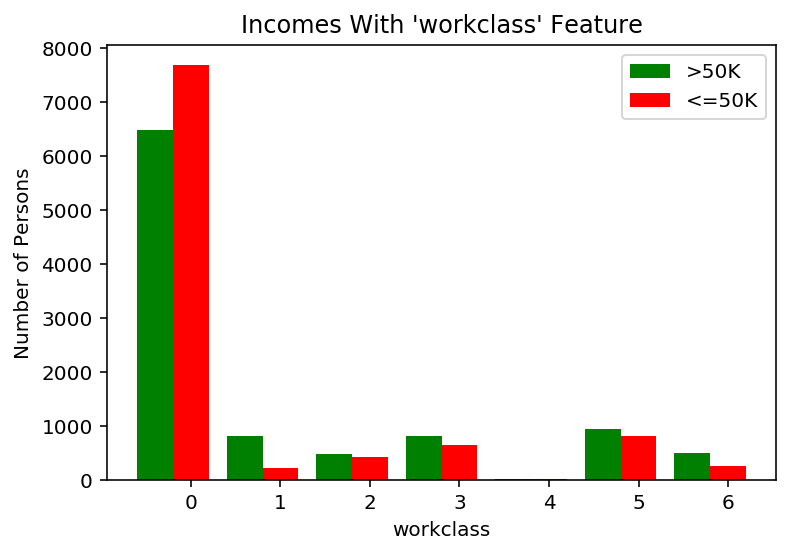

0-- Private
1-- Self-emp-inc
2-- State-gov
3-- Local-gov
4-- Without-pay
5-- Self-emp-not-inc
6-- Federal-gov


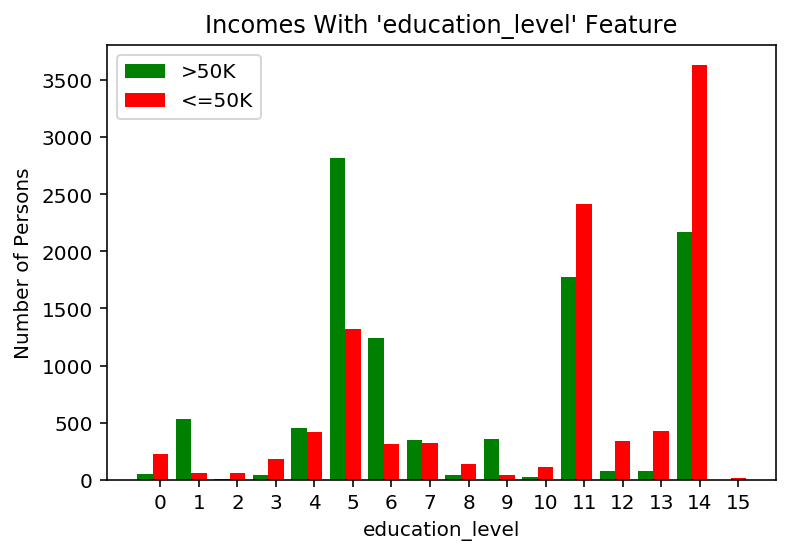

0-- 7th-8th
1-- Prof-school
2-- 1st-4th
3-- 9th
4-- Assoc-voc
5-- Bachelors
6-- Masters
7-- Assoc-acdm
8-- 12th
9-- Doctorate
10-- 5th-6th
11-- Some-college
12-- 10th
13-- 11th
14-- HS-grad
15-- Preschool


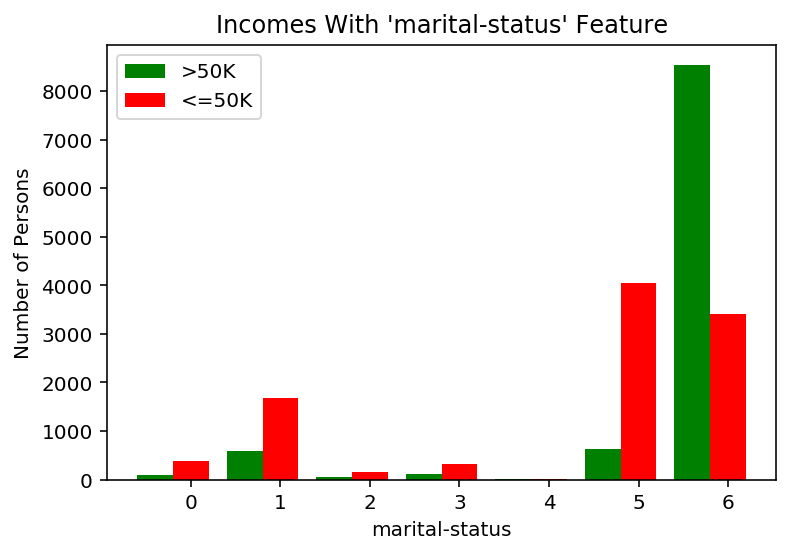

0-- Separated
1-- Divorced
2-- Married-spouse-absent
3-- Widowed
4-- Married-AF-spouse
5-- Never-married
6-- Married-civ-spouse


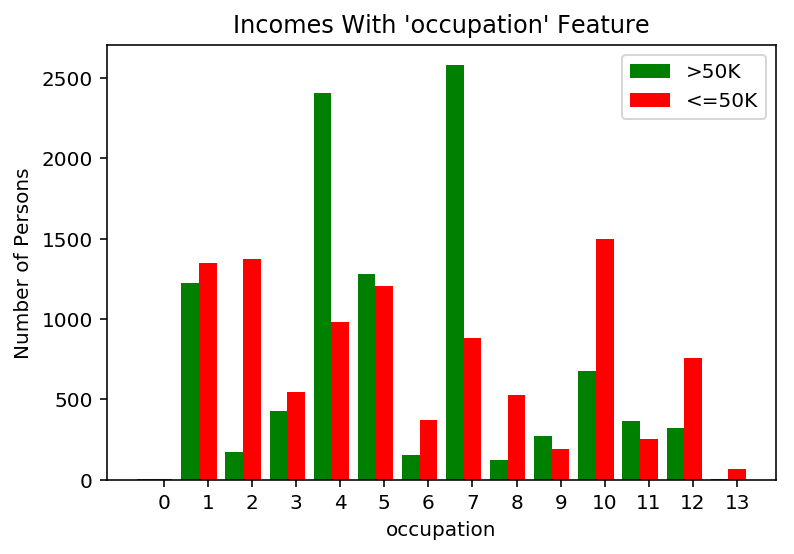

0-- Armed-Forces
1-- Craft-repair
2-- Other-service
3-- Transport-moving
4-- Prof-specialty
5-- Sales
6-- Farming-fishing
7-- Exec-managerial
8-- Handlers-cleaners
9-- Protective-serv
10-- Adm-clerical
11-- Tech-support
12-- Machine-op-inspct
13-- Priv-house-serv


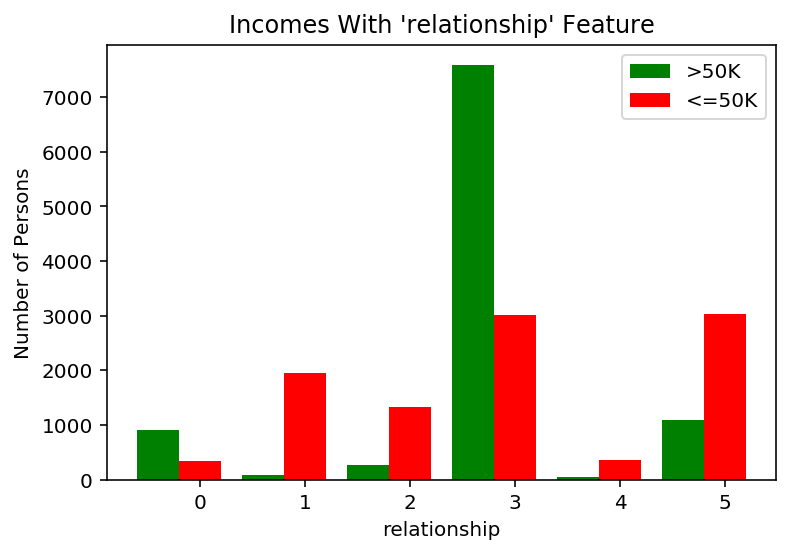

0-- Wife
1-- Own-child
2-- Unmarried
3-- Husband
4-- Other-relative
5-- Not-in-family


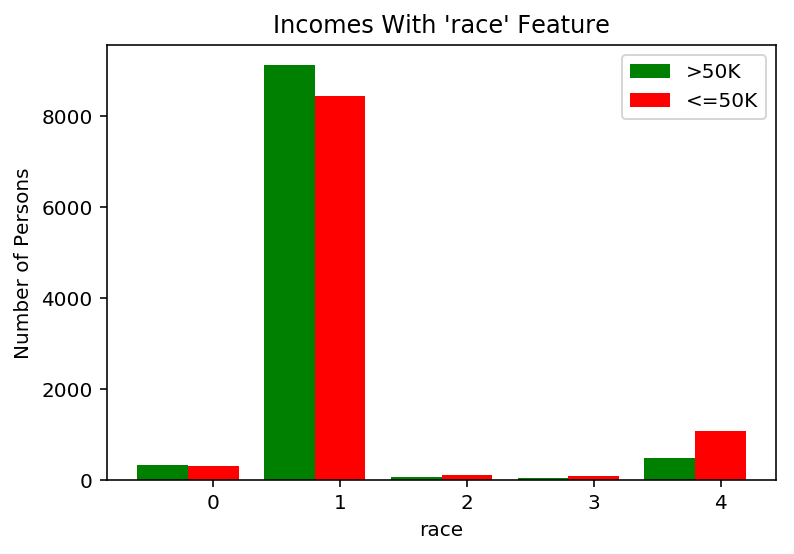

0-- Asian-Pac-Islander
1-- White
2-- Amer-Indian-Eskimo
3-- Other
4-- Black


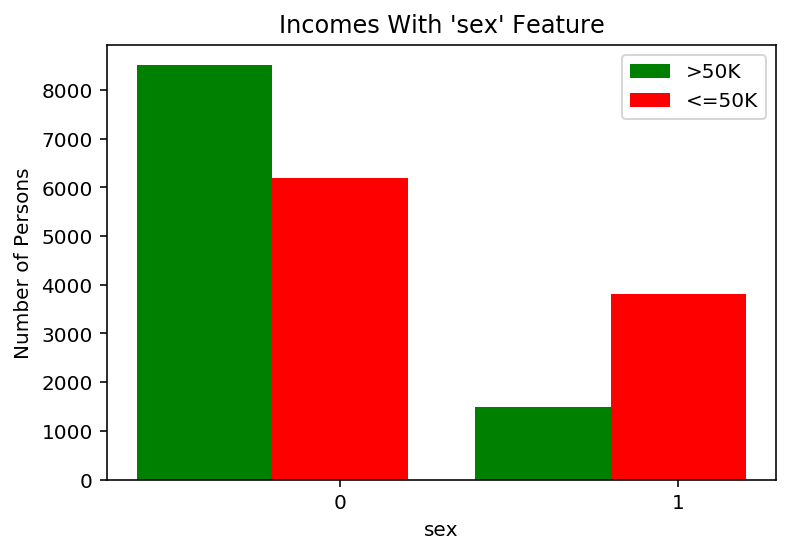

0-- Male
1-- Female


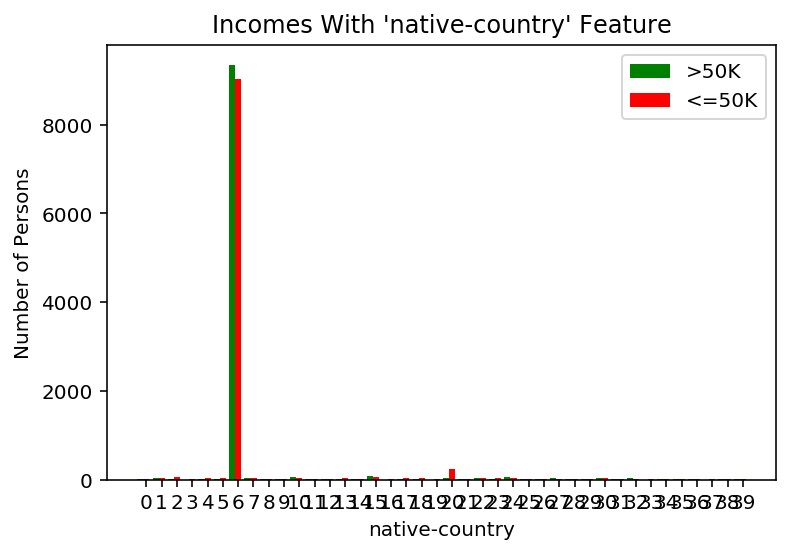

0-- Iran
1-- Cuba
2-- Puerto-Rico
3-- Outlying-US(Guam-USVI-etc)
4-- El-Salvador
5-- Guatemala
6-- United-States
7-- China
8-- Thailand
9-- Haiti
10-- Germany
11-- Columbia
12-- Hungary
13-- Dominican-Republic
14-- Poland
15-- Philippines
16-- Trinadad&Tobago
17-- Vietnam
18-- South
19-- Honduras
20-- Mexico
21-- Portugal
22-- England
23-- Jamaica
24-- India
25-- Yugoslavia
26-- Greece
27-- Japan
28-- Taiwan
29-- Nicaragua
30-- Canada
31-- Hong
32-- Italy
33-- Scotland
34-- France
35-- Cambodia
36-- Ecuador
37-- Laos
38-- Peru
39-- Ireland


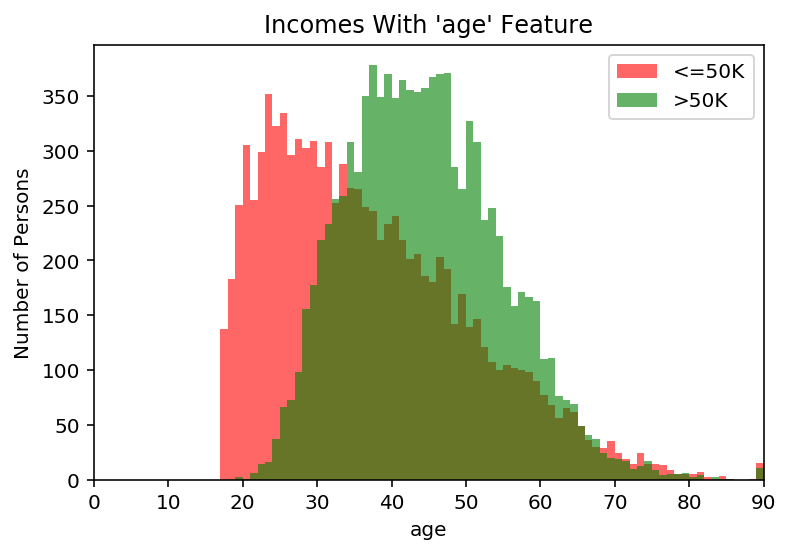

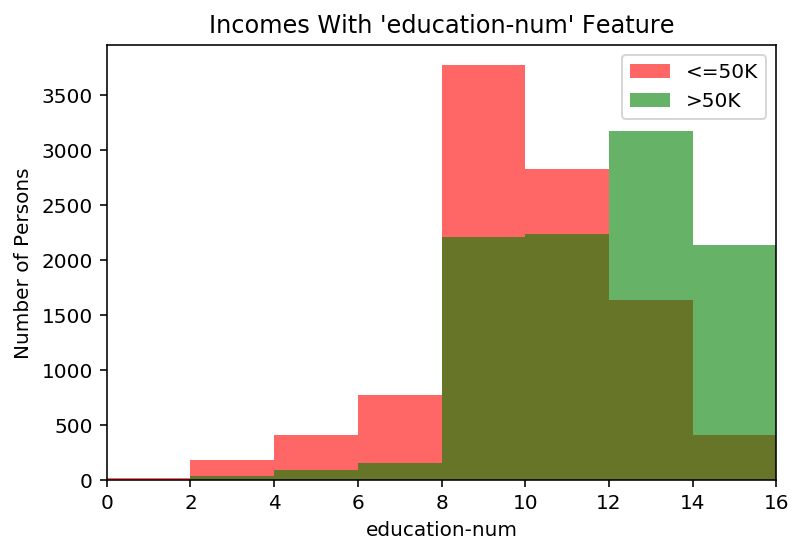

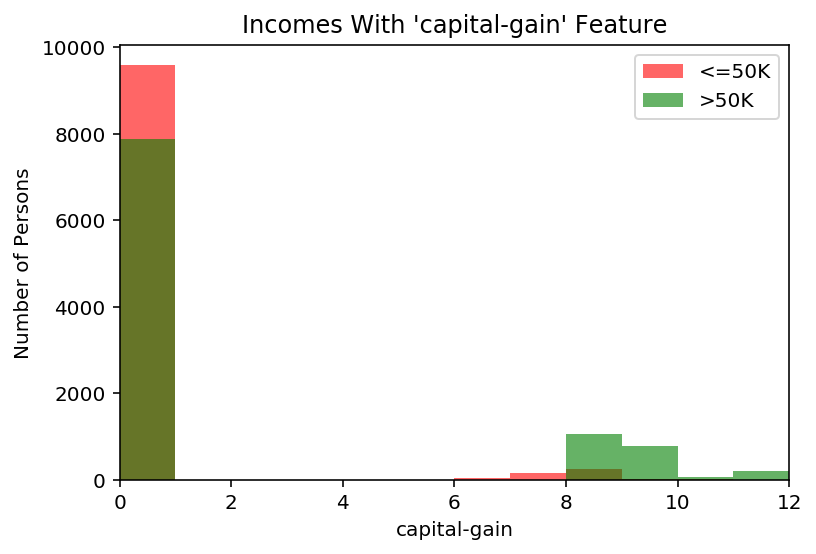

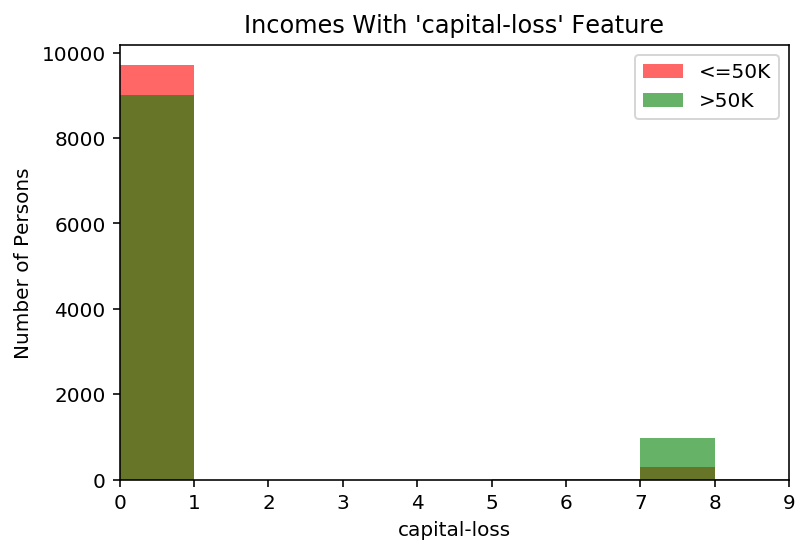

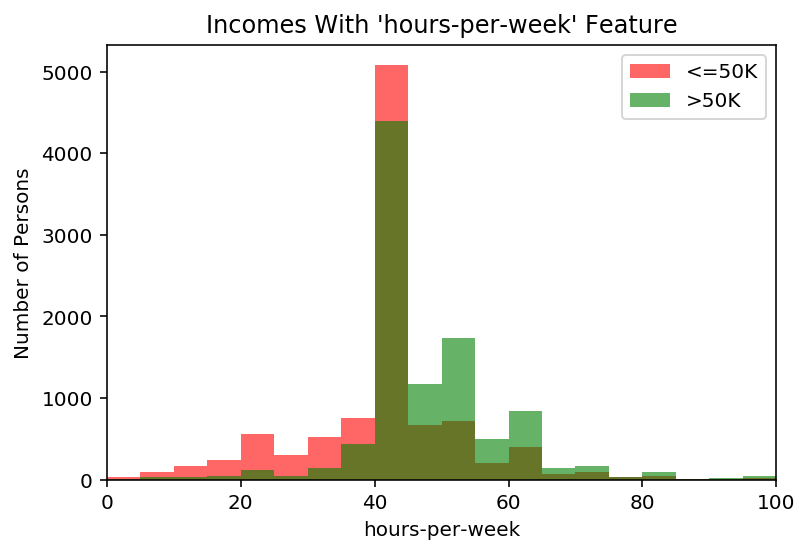

In [15]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

## 分别选出visual_num个正样本和负样本
visual_num = 10000

pos = (data.loc[(data['income'] == ">50K")]).iloc[:visual_num]
neg = (data.loc[(data['income'] != ">50K")]).iloc[:visual_num]

## 将两种样本合并起来
dis_data = pd.concat([pos, neg], axis = 0)

## 将"capital-gain", "capital-loss"这两个特征进行log缩放
skewed_keys = ['capital-gain', 'capital-loss']
dis_data[skewed_keys] = dis_data[skewed_keys].apply(lambda x: np.log(x + 1))

## 区分类别特征和连续特征
category_features = ["workclass", "education_level", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
number_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

all_features = category_features + number_features

## 显示特征和label之间的关系,本来想写一个循环，把所有的图片都打印出来，但是效果不好，就改成单个显示了
for i, key in enumerate(all_features):
    ## 类别特征
    if key in category_features:
        ## 该特征的取值列表
        values = list(set(dis_data[key].values))

        ## 生成一个dataframe，该dataframe里面的每一行代表这个特征的具体类别
        frame = pd.DataFrame(index=list(range(len(values))), columns=[key, '>50K', '<=50K'])
        
        for j, value in enumerate(values):
            frame.loc[j] = [value, len(dis_data.loc[(dis_data[key] == value) & (dis_data['income'] == ">50K")]), \
                           len(dis_data.loc[(dis_data[key] == value) & (dis_data['income'] != ">50K")])]
        ## 显示该特征
        width = 0.4
        
        for j in range(len(frame)):
            a = plt.bar(j-width, frame.loc[j, '>50K'], width, color='g')
            b = plt.bar(j, frame.loc[j, '<=50K'], width, color='r')
            
            plt.xticks(np.arange(len(frame)), np.arange(len(values)))
            plt.legend((a[0], b[0]),('>50K', '<=50K'), framealpha = 0.8)
        
        plt.xlabel(key)
        plt.ylabel('Number of Persons')
        plt.title('Incomes With \'%s\' Feature'%(key))
        plt.show()
        ## 打印特征和数字的映射
        for index, value in enumerate(values):
            print "{0}--{1}".format(index, value)
    ## 连续特征
    else:
        # Divide the range of data into bins and count survival rates
        min_value = dis_data[key].min()
        max_value = dis_data[key].max()
        value_range = max_value - min_value

        # get bins
        if(key == 'education-num'):
            bins = np.arange(0, dis_data['education-num'].max() + 2, 2)
        elif(key == 'Age'):
            bins = np.arange(0, dis_data['Age'].max() + 10, 10)
        elif(key=='hours-per-week'):
            bins = np.arange(0, dis_data['hours-per-week'].max() + 5, 5)
        else:
            bins = np.arange(0, dis_data[key].max() + 1, 1)
            
        # 绘图
        neg = dis_data[dis_data['income'] != ">50K"][key].reset_index(drop = True)
        pos = dis_data[dis_data['income'] == ">50K"][key].reset_index(drop = True)
        plt.hist(neg, bins = bins, alpha = 0.6,
                 color = 'red', label = '<=50K')
        plt.hist(pos, bins = bins, alpha = 0.6,
                 color = 'green', label = '>50K')
    
        # Add legend to plot
        plt.xlim(0, bins.max())
        plt.legend(framealpha = 0.8)

        plt.xlabel(key)
        plt.ylabel('Number of Persons')
        plt.title('Incomes With \'%s\' Feature'%(key))
        plt.show()

<font color=#009500 size=2> - 特征1:marital-status,刚开始觉得很意外，婚姻状态和收入有什么关系？仔细分析一下，没钱还结什么婚，所以从没结婚的大部分收入小于50K。然后上面的数据还显示，离婚的人，大部分收入都小于50K，所以离婚的根源还是穷！然后还发现，婚姻状况好的大部分都是收入50K以上的，是啊，有钱了，其他问题都不是问题。我感觉这个特征和relationship这个特征有一些相似，relationship也显示结婚有家庭的人的收入，大部分都超过50K。
<font color=#009500 size=2> - 特征2:education-level,教育程度和收入的关系是很直观的，教育程度越高，收入相应地越高，比如一个博士，基本上就可以认定他年收入超过50K，大学以下教育程度的人很少有年收入50K的。个人觉得这个特征与education-num很相似，都表达了受教育程度越高，越有可能超过50K。
<font color=#009500 size=2> - 特征3:Age,这个也很明显，从图上可以看出，35岁左右是一个分水岭，35岁之前大多数人的收入都低于50K，35岁之后情况就发生了变化，大部分人收入高于50K。
<font color=#009500 size=2> - 特征4:occupation，职业和收入是非常相关的，比如上图中显示行政管理的人大部分工资都很高，然而Craft-repair的人基本上都很低。
<font color=#009500 size=2> - 特征5:hours-per-week,不得不承认，收入在大部分的情况下适合工作时间成正比的，所以。。。。

* 结论，不知道是不是因为图表显示的原因，连续的数值特征表现出了与label的更强的相关性"age", "education-num", "capital-gain", "capital-loss", "hours-per-week"，经过考虑，我还是选择了上述5个特征，按照相关性进行排序的话就是：age-->education-level-->occupation-->hours-per-week-->marital-status

### 提取特征重要性

下面从`scikit-learn`中选择随机森林分类器，因为他是有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

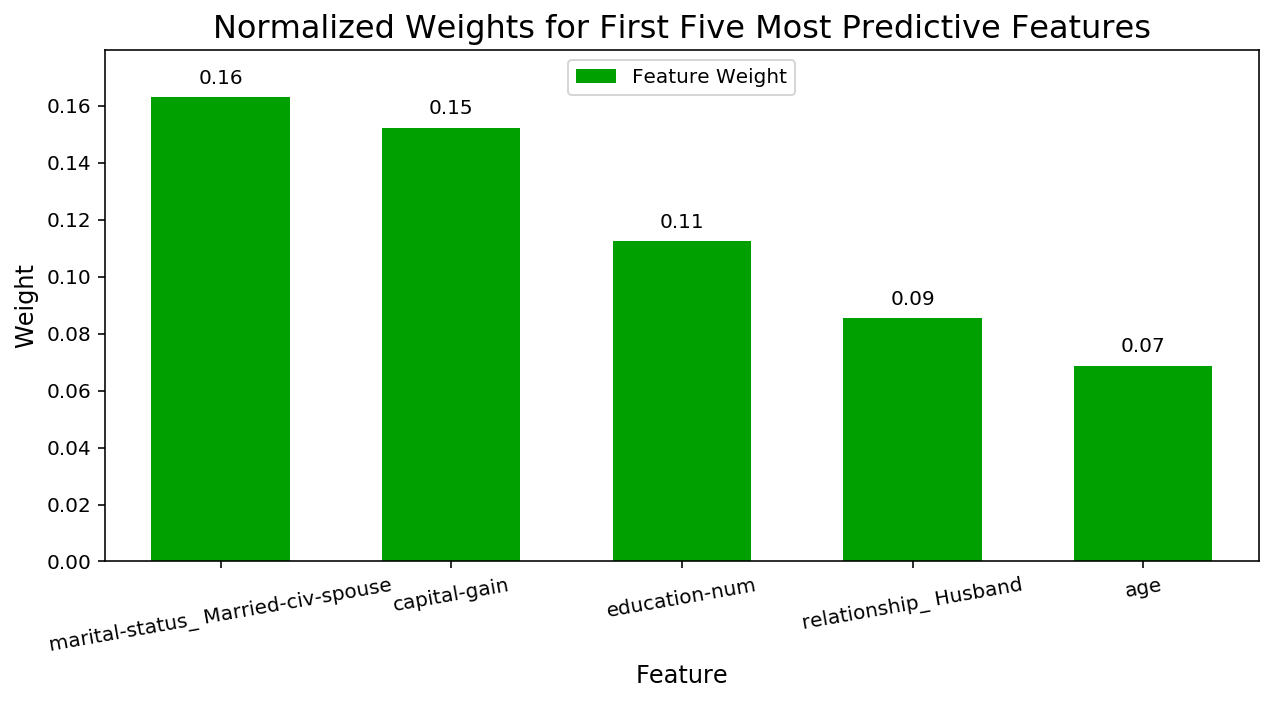

In [16]:
# 导入一个有'feature_importances_'的监督学习模型
from sklearn.ensemble import RandomForestClassifier

# 在训练集上训练一个监督学习模型
model = RandomForestClassifier(n_estimators=128, max_depth=16, min_samples_leaf=4, random_state=0)
model.fit(X_train, y_train)
# 提取特征重要性
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

### 提取特征重要性


<font color=#009500 size=2>这五个特征在之前的图标中确实显示了比较高的重要性，和之前在问题6中选出的比较类似，但是重要性的顺序几乎都猜反了。对于上述5个特征，其重要性超过了0.5，这五个特征在决策的时候应该起到很大的作用(要知道在one-hot encoding之后特征数量变成了103个，现在5个就达到了0.5的重要性)。在问题6中，我将年龄列在了第一位，是因为我加上了自己的认识，并没有专门从数据观察得到，如果只从数据出发的话，婚姻状况确实是重要性最明显的特征。对于capital-gain这个特征确实应该被加进来，因为这直接和收入相关，从图上可以看出如果对于资产收益大于8的（经过log缩放之后），我们可以直接认为其年收入超过50K，我没有将其加入的原因是因为资产收益大于8的毕竟只是少数，多数人的资产收益是等于0的，而在这些资产收益等于0的人中，收入大于和小于50K的人几乎是对半分的，所以在大部分的情况下，根据资产收益是不容易区分年收入的。然后下一个特征education-num，我认为他是和education-level差不多的，但是education-level并没有出现在5个特征中。同样，下一个relationship的特征我认为其和marital-status在某种程度上来说表达的是一种意思，所以没有将其列为重要特征。</font>

### 特征选择

如果我们只是用可用特征的一个子集的话模型表现会怎么样？通过使用更少的特征来训练，在评价指标的角度来看我们的期望是训练和预测的时间会更少。从上面的可视化来看，我们可以看到前五个最重要的特征贡献了数据中**所有**特征中超过一半的重要性。这提示我们可以尝试去**减小特征空间**，简化模型需要学习的信息。下面代码单元将使用你前面发现的优化模型，并**只使用五个最重要的特征**在相同的训练集上训练模型。

In [17]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
start = time.time()
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time.time()

clf_on_reduced_train_time = round(end-start, 2)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 计算在完整数据集中的训练时间
start = time.time()
(clone(best_clf)).fit(X_train, y_train)
end = time.time()

full_train_time = round(end-start, 2)

# 对于每一个版本的数据汇报最终模型的分数
print "Final Model trained on full data(training time:%.2f s)\n------" % (full_train_time)
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data(training time:%.2f s)\n------" % (clf_on_reduced_train_time)
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5))

Final Model trained on full data(training time:3.01 s)
------
Accuracy on validation data: 0.8611
F-score on validation data: 0.7419

Final Model trained on reduced data(training time:1.22 s)
------
Accuracy on validation data: 0.8506
F-score on validation data: 0.7120


###  特征选择的影响

<font color=#009500 size=2>在只有5个特征的数据集上的两个分数相对于完整数据集的两个分数有所下降，下降了1%左右，但是训练的时间缩短了60%左右。如果训练时间是一个重要的考虑因素，那么肯定会选择使用部分的特征作为训练集。特别是在使用网格搜索的时候，在训练时间上，使用部分特征将表现出更明显的优势。

### 在测试集上测试模型

终于到了测试的时候，记住，测试集只能用一次。

In [18]:
#TODO test your model on testing data and report accuracy and F score
test_pred = best_clf.predict(X_test)

test_accuracy = accuracy_score(y_test, test_pred)
test_fbeta_score = fbeta_score(y_test, test_pred, beta = 0.5)

print ("test accuracy is:{:.2f}".format(test_accuracy))
print ("test fbeta score is:{:.2f}".format(test_fbeta_score))

test accuracy is:0.86
test fbeta score is:0.74


<font color=#009500 size=2>对于我们之前讨论的三个模型(决策树，SVM，随机森林)，我们经过在部分训练集上训练，由于SVM的训练时间过长，验证正确率以及fbeta的分数太低，将其淘汰（其实我对于这个过程有疑问，仅仅凭借默认参数训练出来的结果就否定一个模型是不是太草率）。由于随机森林在验证集上表现由于决策树，所以我们选择随机森林。进一步地，我们需要选择随机森林的模型参数，然后我们对随机森林的三个超参数进行了网格搜索，得出了表现最好的一组超参数，得出了best_clf这个表现最好的模型。然后我们又利用随机森林的特征重要性排序的特点，得出了5个最重要的特征，然后基于这5个特征的训练集再一次训练我们选定的best_clf这个模型。发现在分数下降不大的情况下，训练时间大大降低，在对训练时间有要求的场景可以考虑采用这个特征的子集用于训练模型。但是最后我还是选择了使用整体数据集进行训练得出的最佳模型，因为分数高总是好的嘛。

> **注意：** 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。